In [10]:
from os import listdir
import pandas as pd
from datetime import datetime
from sklearn.decomposition import PCA
from data_processor import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

In [11]:
def collect_data_from_csvs(league = None):
    
    path_to_files = "players/"
    extension = ".csv"

    files = listdir(path_to_files)
    csv_files = [file for file in files if extension in file]

    data = pd.DataFrame()
    
    if league == None:
        for file in csv_files:

            df = pd.read_csv(path_to_files + file, encoding = "latin1")
            df = convert_kickoff_to_date(df)
            data = pd.concat([data, df])
    else:
        df = pd.read_csv(path_to_files + league + extension, encoding = "latin1")
        df = convert_kickoff_to_date(df)
        data = pd.concat([data, df])

    data = data.sort_values(by = "kickoff")
    data = data.reset_index(drop = True)
    
    return data


def get_team_df(df, date, team):

    lineup = lineup_by_date(df, date, team)
    cor = team_corners(df, date, team)
    goal = goalkeeper(df, lineup)
    att = attack(df, lineup)
    mid = midfield(df, lineup)
    _def = defence(df, lineup)
    team_dict = {**cor, **goal, **att, **mid, **_def}
    team_df = pd.DataFrame(team_dict, index = [0])
    team_df['kickoff'] = date
    team_df['team'] = team
    team_df['code'] = codes[team]

    return team_df


def get_teams_df(league_name):

    data = collect_data_from_csvs(league = league_name)
    teams = list(set(data.team))
    teams_df = pd.DataFrame()

    for team in teams:
        df = data[data.team == team]
        dates = sorted(list(set(df.kickoff)))
        for date in dates:
            team_df = get_team_df(df, date, team)
            teams_df = pd.concat([teams_df, team_df])
            teams_df = teams_df.fillna(method = 'ffill', axis = 'columns')
    teams_df = teams_df.sort_values(by = "kickoff")
    teams_df = teams_df.reset_index(drop = True)
    
    return teams_df


def scale(data):
    
    index = data.index
    columns = data.columns
    data = preprocessing.scale(data)
    data = pd.DataFrame(data)
    data.index = index
    data.columns = columns
    
    return data


def get_columns_by_position(teams_df):

    attack_cols = [column for column in teams_df.columns if '_f' in column] + ['COR']
    midfield_cols = [column for column in teams_df.columns if '_m' in column]
    defence_cols = [column for column in teams_df.columns if '_d' in column] + ['SAV', 'GK', 'GC']

    positions = {'attack' : attack_cols,
                 'midfield' : midfield_cols,
                 'defence' : defence_cols}

    return positions


def apply_pca_to_positions(positions, n_components):
    
    pca = PCA(n_components)
    pca_positions = {}
    for position in positions:
        features = teams_df[positions[position]]
        scaled_position = scale(features)
        pca_position = pca.fit_transform(scaled_position)
        pca_positions[position] = [value for array in pca_position for value in array]
    
    return pca_positions

def animate(league_df):

    _3d = plt.figure(figsize=(8,8)).gca(projection='3d')
    _3d.scatter(league_df.attack, 
                     league_df.midfield, 
                     league_df.defence,
                     s = 50,
                     cmap = 'nipy_spectral')
    _3d.set_xlabel('attack')
    _3d.set_ylabel('midfield')
    _3d.set_zlabel('defence')
    _3d.set_xlim([-3, 4])
    _3d.set_ylim([-2, 6])
    _3d.set_zlim([-5, 3])
    
    plt.title(list(league_df.team)[0])
    
    plt.show();

In [3]:
league = 'premier-league'
number_of_teams = 20

In [4]:
data = collect_data_from_csvs(league = league)
teams = list(set(data.team))
codes = {team : number for number, team in enumerate(teams)}
teams_df = get_teams_df(league)
teams_df = teams_df[number_of_teams:]
teams_df.reset_index(drop = True, inplace = True)

In [5]:
positions = get_columns_by_position(teams_df)
positions_pca = apply_pca_to_positions(positions, 1)

In [6]:
league_df = pd.DataFrame(positions_pca)
league_df['team'] = teams_df['team']
league_df['kickoff'] = teams_df['kickoff']
league_df['code'] = teams_df['code']

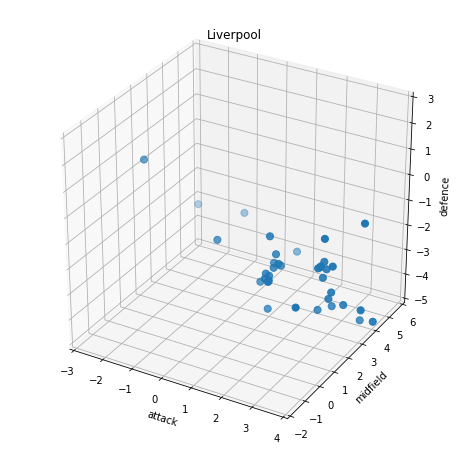

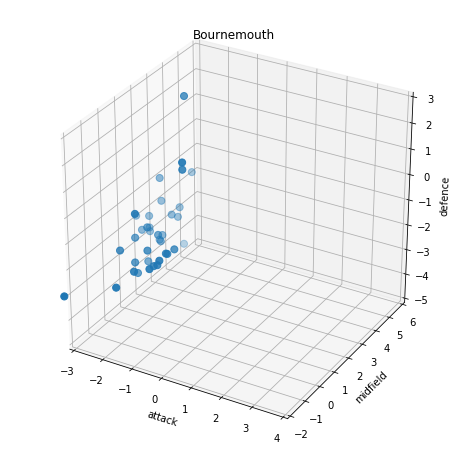

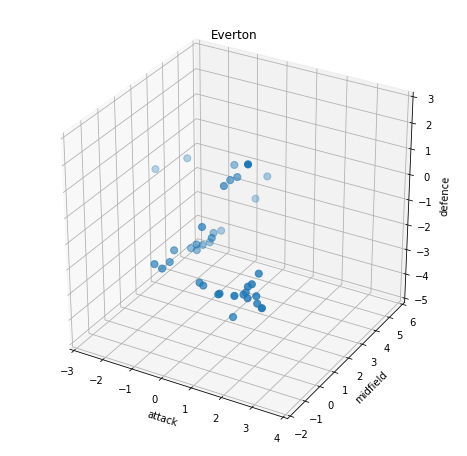

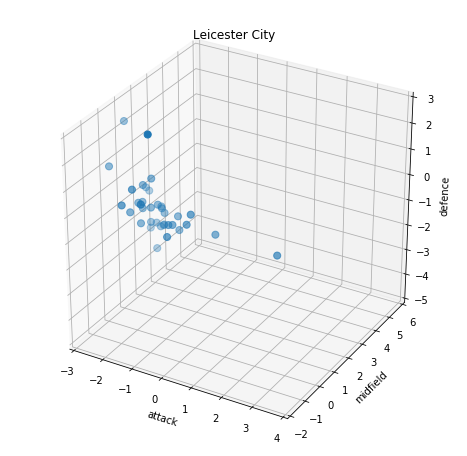

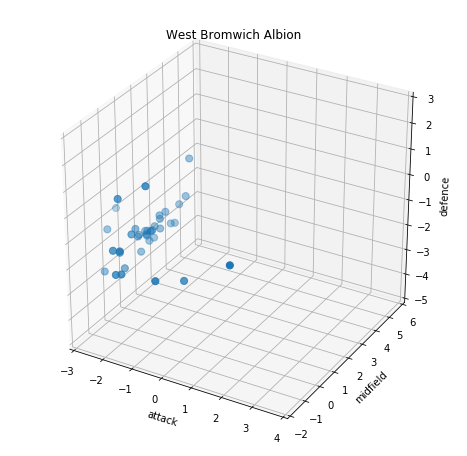

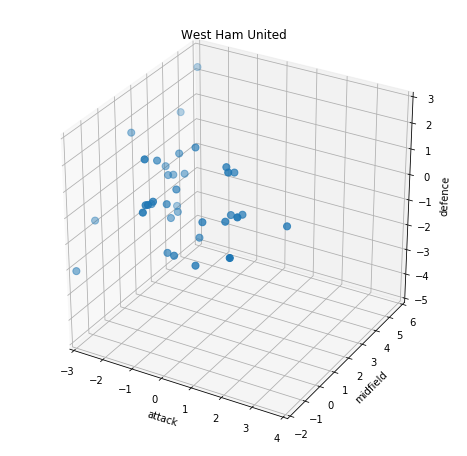

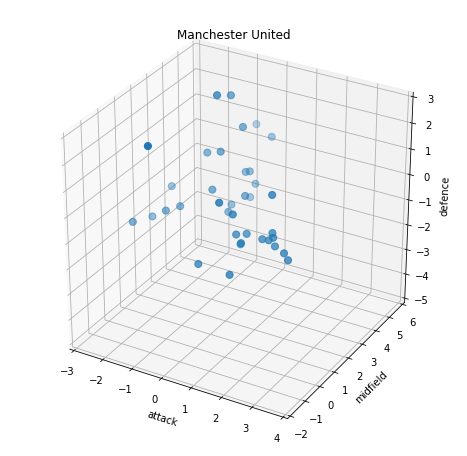

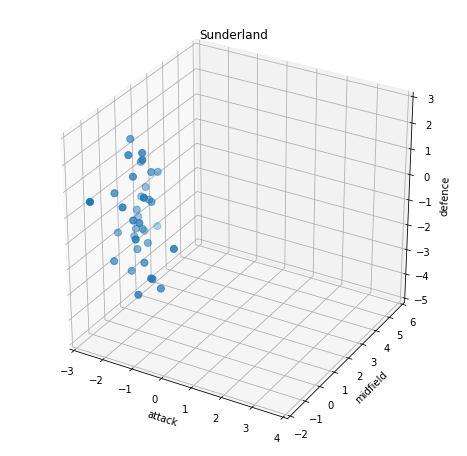

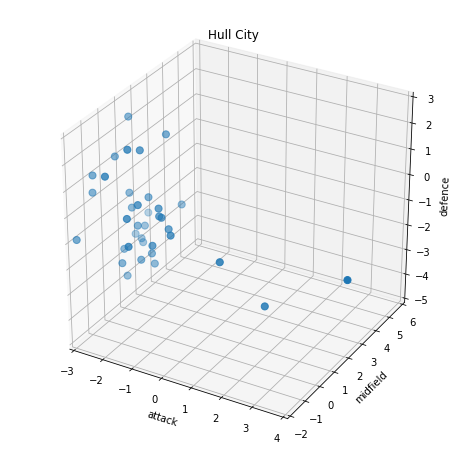

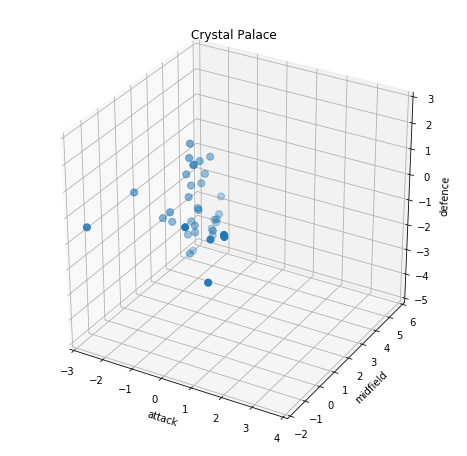

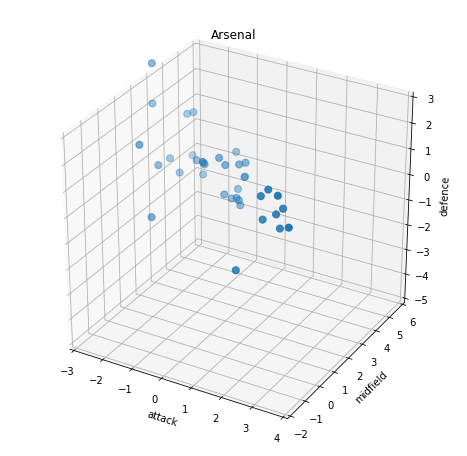

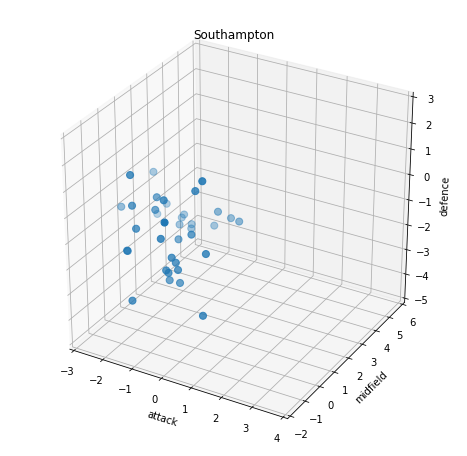

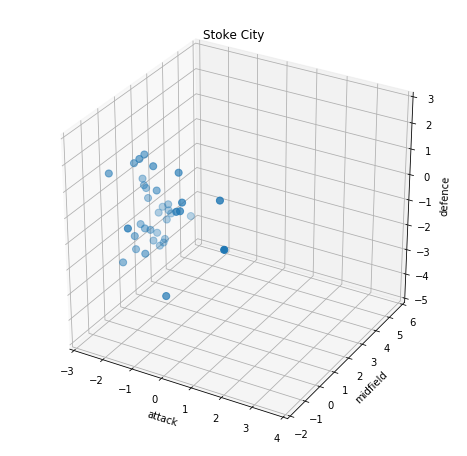

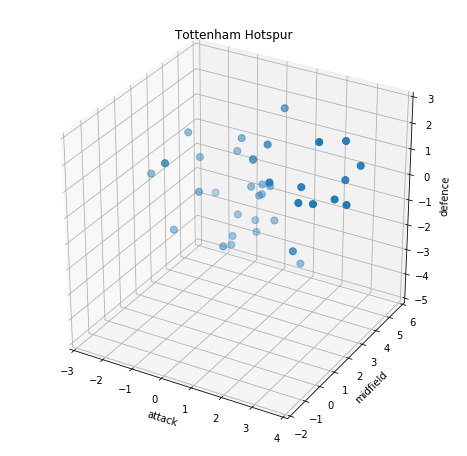

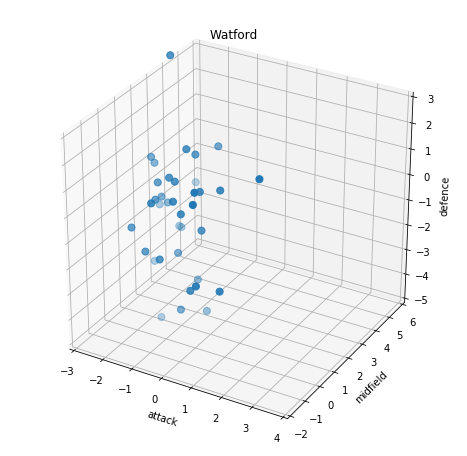

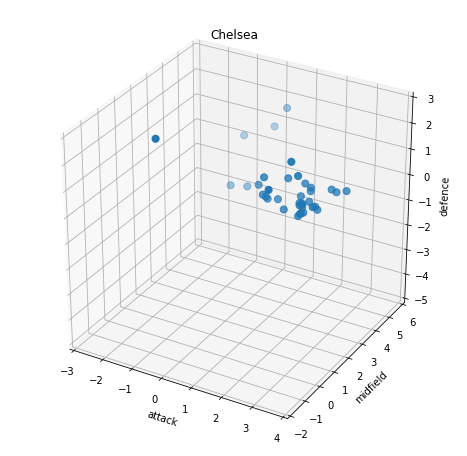

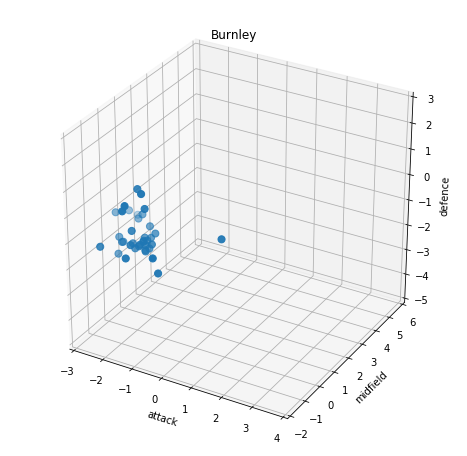

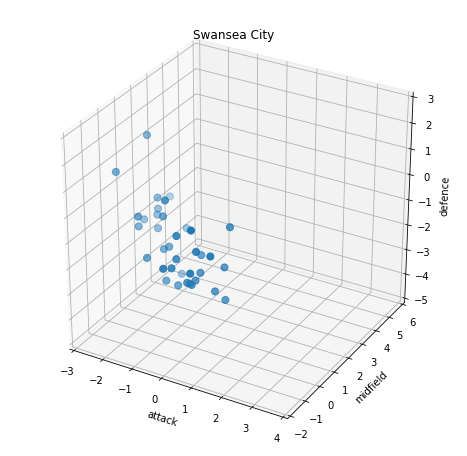

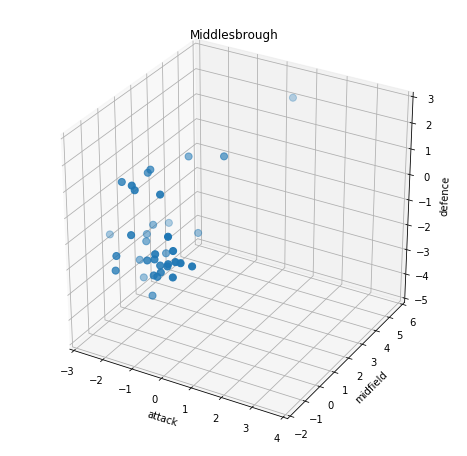

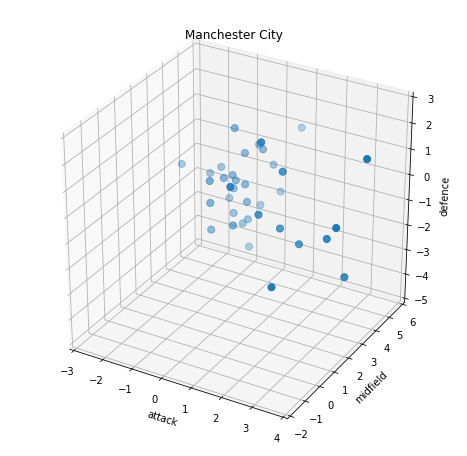

In [13]:
# visualise premier league season 2016-2017
for code in range(20):
    animate(league_df[league_df.code == code]);